# Average Gate Fidelities for the CV device

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np; pi = np.pi

from tqdm.notebook import tqdm

from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *

from qaoa_with_cat_qubits.cvdevice import KPOProcessor
from qaoa_with_cat_qubits.plotlib import plotlib
plotlib.update_settings(usetex=True)

## Setup parameters for single-qubit gates

In [278]:
## KPO parameters
kpo = KPOProcessor(N=1,alpha=3,num_lvl=30)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [sigma_x, sigma_y, sigma_z]

## RZ-gate

In [4]:
avg_fid = []
## List of angles
arg_list = np.linspace(-np.pi/2,np.pi/2,20)

## Loop over the list of angles and calculate the average gate fidelity
for arg in tqdm(arg_list):
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RZ", 0, None, arg)
    
    ## Ideal gate
    U = (-1j*arg/2*sigma_z).expm()
    
    ## Average Gate Fidelity
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

  0%|          | 0/20 [00:00<?, ?it/s]

In [145]:
print("Average gate fidelity:",np.mean(avg_fid))

Average gate fidelity: 0.9964767815142028


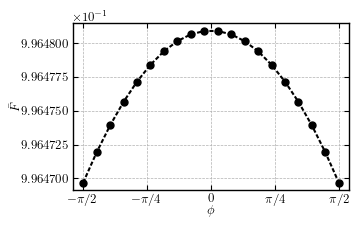

In [146]:
fig, ax = plotlib.create_fig()
ax.plot(arg_list, avg_fid,'ko',linestyle=(0, (2, 1)))
ax.set_xlabel(r'$\phi$');
ax.set_ylabel(r'$\bar F$');
ax.set_xlim([-1.7,1.7])
ax.set_xticks([-pi/2,-pi/4,0,pi/4,pi/2])
ax.set_xticklabels([r'$-\pi/2$',r'$-\pi/4$',r'$0$',r'$\pi/4$',r'$\pi/2$'])
ax.grid(linestyle='--', linewidth=.5)
# Format the exponents nicely
ax.ticklabel_format(axis="y", style="sci", scilimits=(-0,-7), useOffset=False, useMathText=False)

### Compute the average gate fidelity for different $\alpha$ and loss-rates

In [313]:
alpha_list = np.linspace(1,3,51)
gamma_list = [1/500,1/1000,1/1500,1/2000]
avg_fid = np.zeros((len(gamma_list),len(alpha_list)))
## KPO parameters
for i, gamma in enumerate(gamma_list):
    for j, alpha in enumerate(alpha_list):
        kpo = KPOProcessor(N=1,alpha=alpha,num_lvl=30,gamma=gamma)
        alpha = kpo._paras['Coherent state']
        num_lvl = kpo._paras['Cut off']

        ## Cat state
        cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
        cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

        ## Computational basis
        up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
        down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

        ## Pauli Matrices in computational basis
        # Identity
        I = up*up.dag() + down*down.dag()
        # sigma z
        sigma_z = up*up.dag() - down*down.dag()
        # sigma x
        sigma_x = up*down.dag() + down*up.dag()
        # sigma y
        sigma_y = 1j*(-up*down.dag() + down*up.dag())
        sigma = [sigma_x, sigma_y, sigma_z]
        
        # pick an argument
        arg = np.pi/2
        
        ## Create quantum circuit
        qc = QubitCircuit(N=1)
        qc.add_gate("RZ", 0, None, arg)
        
        ## Ideal gate
        U = (-1j*arg/2*sigma_z).expm()
        
        ## Average Gate Fidelity
        F = 0
        for sigma_k in sigma:
            ## Master equation
            result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
            final_state = result.states[-1]
            ## Target state
            target_state = U * sigma_k * U.dag()
            F += (target_state * final_state).tr().real
        avg_fid[i,j]= (1/2 + 1/12 * F)

In [317]:
np.save('../../data/average_gate_fidelity/cv_avg_fid_rz_vs_alpha_and_loss_rate', avg_fid)

In [318]:
avg_fid=np.load('../../data/average_gate_fidelity/cv_avg_fid_rz_vs_alpha_and_loss_rate.npy')

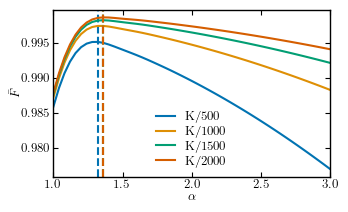

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plotlib.create_fig()
colormap = sns.color_palette()

ax.plot(alpha_list, avg_fid[0,:],label="K/500")
# Plot the vertical line using plt.axvline()
ax.axvline(x=alpha_list[np.argmax(avg_fid[0,:])], color=colormap[0], linestyle='--')

ax.plot(alpha_list, avg_fid[1,:],label="K/1000")
# Plot the vertical line using plt.axvline()
ax.axvline(x=alpha_list[np.argmax(avg_fid[1,:])], color=colormap[1], linestyle='--')

ax.plot(alpha_list, avg_fid[2,:],label="K/1500")
# Plot the vertical line using plt.axvline()
ax.axvline(x=alpha_list[np.argmax(avg_fid[2,:])], color=colormap[2], linestyle='--')

ax.plot(alpha_list, avg_fid[3,:],label="K/2000")
# Plot the vertical line using plt.axvline()
ax.axvline(x=alpha_list[np.argmax(avg_fid[3,:])], color=colormap[3], linestyle='--')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\bar F$')
plt.legend()
fig.savefig('../../figures/fig-avg-fid-vs-alpha-and-loss.pdf')

In [352]:
alpha_list[np.argmax(avg_fid[2,:])]

1.3599999999999999

## RX-gate

To perform $R_x(\theta)$ on a qubit, we use the detuning $\Delta$. When $\Delta$ is slowly increased from zero to a value $\Delta_0$ near to $G$ and then decreased to zero, the even and odd cat states, obtain dynamical phase factors depending on their energy shifts due to the nonzero detuning. Thus the qubits change as follow ($\theta$ is the phase difference between the even and odd cat state)
$$
\begin{align}
\alpha_0|\bar 0\rangle +  \alpha_1|\bar 1 \rangle =& \frac{\alpha_0+\alpha_1}{2}(|\bar 0\rangle + |\bar 1 \rangle)
\frac{\alpha_0-\alpha_1}{2}(|\bar 0\rangle - |\bar 1 \rangle) \\
\rightarrow & \frac{\alpha_0+\alpha_1}{2}(|\bar 0\rangle + |\bar 1 \rangle)
\frac{\alpha_0-\alpha_1}{2}e^{i\theta}(|\bar 0\rangle - |\bar 1 \rangle) \\
=&  e^{-i\theta/2}\left[\left(\alpha_0\cos\frac{\theta}{2}-i\alpha_1\sin\frac{\theta}{2}\right)|\bar 0 \rangle 
+ \left(\alpha_1\cos\frac{\theta}{2}-i\alpha_0\sin\frac{\theta}{2}\right)|\bar 1 \rangle \right] \\
=& e^{-i\theta/2}R_x(\theta)(\alpha_0|\bar 0\rangle +\alpha_1|\bar 1\rangle)
\end{align} 
$$
Thus $R_x(\theta)$ is achieved by this detuning protocol.

Below we present numerical simulations. In the simulations below we set $G = 4K$ and $T_g = 10/K$, the initial state $|\psi_i\rangle$ is set to $(|\bar 0\rangle +i|\bar 1\rangle)/\sqrt{2}$ and the Hilbert space is truncated to a photon number of $16$. The detuning protocol is controlled as follows
$$
\Delta(t) = \Delta_0\sin^2\frac{\pi t}{T_g}.
$$

In [451]:
num_lvl = 20 # number of levels
a = destroy(num_lvl) # annihilation operator
alpha = 1 # amplitude
G = alpha**2 # two photon pump amplitude
T_g = 10 # gate time

cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# initial state
psi0 = up #(up+1j*down).unit()

# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()

# detuning
def Delta(t,args):
    Delta_0 = args['Delta_0']
    return Delta_0 * pow(np.sin(np.pi*t/T_g),2)

def rx(theta):
    return (-1j*theta/2*sigma_x).expm()

# Hamiltonian
H0 = - pow(a.dag(),2)*pow(a,2) + G * (pow(a.dag(),2) + pow(a,2))
H1 = - a.dag()*a
H_tot = [H0,[H1,Delta]]

### Find the best $\theta$ with respect to average gate fidelity

In [452]:
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2)
down = (cat_plus - cat_minus)/np.sqrt(2)

# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
# list with pauli matrices
sigma = [I, sigma_x, sigma_y, sigma_z]

# collapse operators
gamma = 1/1500
c_ops = np.sqrt(gamma)*a

# time array
tlist = np.linspace(0,T_g,200)

# angle array
theta_list = np.linspace(0,np.pi,180,endpoint=False)

# amplitude array
Delta_0_list = np.linspace(0,0.9,20,endpoint=False)

max_f = [] # max fidelity
max_theta = [] # max angle
# For precise calculation
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8)
for Delta_0 in tqdm(Delta_0_list):
    d = 2
    f = []
    epsilon = []
    for sigma_j in sigma:
        e = mesolve(H_tot, sigma_j, tlist, c_ops = c_ops, options=opt, args = {'Delta_0' : Delta_0})
        epsilon.append(e.states[-1])
    # find the theta that maximize the avg gate fidelity    
    for theta in theta_list:
        U = rx(theta) # target state
        F = 0
        for idx, rho in enumerate(epsilon):
            F = F + abs((U*sigma[idx]*U.dag()*rho).tr())
        f.append((F + d**2) / (d**2*(d+1)))
    max_theta.append(theta_list[np.argmax(f)])
    max_f.append(np.max(f))

  0%|          | 0/20 [00:00<?, ?it/s]

In [453]:
xdata = np.array(Delta_0_list)
ydata = np.array(max_theta)

# Do a polyfit
z = np.polyfit(xdata, ydata, deg=4)
p = np.poly1d(z)

In [454]:
z

array([-7.32159876e-01,  9.74255497e-01,  4.88620382e-01,  2.88478631e+00,
       -2.67318215e-03])

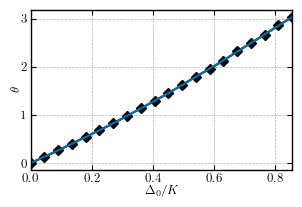

In [455]:
fig, ax = plt.subplots();
#plt.subplot(211)
ax.plot(Delta_0_list, max_theta, 'kD-');
ax.plot(xdata, p(xdata))
plt.grid(linestyle='--', linewidth=.5);
plt.xlabel(r'$\Delta_0/K$');
plt.ylabel(r'$\theta$');
#plt.ticklabel_format(axis="y", style="sci", useOffset=False, scilimits=(0,0), useMathText=False);
#plt.savefig('figs/fig-arg-rx.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [265]:
import numpy as np
from scipy.optimize import brentq

# Define the given value of f(x)
y_given = 0.1

# Define the function to find the root of
def func(x):
    return p(x) - y_given

# Find the root using the brentq method, searching in the interval (0, some_large_value)
# You may need to adjust the interval depending on the polynomial and the given value of y
x_value = brentq(func, 0, 13)

print(f"The value of x for which f(x) = {y_given} is x = {x_value}")

# Compute the average gate fidelity 

# For precise calculation
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8)
F = 0 
for sigma_j in sigma:
    res = mesolve(H_tot, sigma_j, tlist, c_ops = c_ops, options=opt, args = {'Delta_0' : x_value})
    rho = res.states[-1]
    U = rx(y_given) # target state
    F = F + (U*sigma_j.dag()*U.dag()*rho).tr()
avg_fid = ((F+d**2)/(d**2*(d+1))).real
print(f"The average gate fidelity is {avg_fid}")    

The value of x for which f(x) = 0.1 is x = 7.186092209304778
The average gate fidelity is 0.9697627694171436


# Avg gate fid

In [447]:
## KPO parameters
kpo = KPOProcessor(N=1,alpha=1.36,num_lvl=20)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [sigma_x, sigma_y, sigma_z]

In [448]:
avg_fid = []
## List of angles
arg_list = np.linspace(0,np.pi,20,endpoint=False)

## Loop over the list of angles and calculate the average gate fidelity
for arg in tqdm(arg_list):
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RX", 0, None, arg)
    arg = arg % (np.pi)
    ## Ideal gate
    U = (-1j*arg/2*sigma_x).expm()
    ## Average Gate Fidelity
    d = 2
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

  0%|          | 0/20 [00:00<?, ?it/s]

In [449]:
print("Average gate fidelity:",np.mean(avg_fid))

Average gate fidelity: 0.9928742722779409


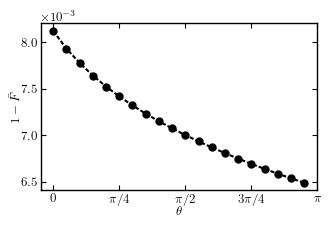

In [450]:
fig, ax = plotlib.create_fig()
ax.plot(arg_list, 1-np.array(avg_fid),'ko',linestyle=(0, (2, 1)))
ax.set_xlabel(r'$\theta$');
ax.set_ylabel(r'$1-\bar F$');
ax.set_xlim([-0.15,pi])
ax.set_xticks([0,pi/4,pi/2,3*pi/4,pi])
#ax.set_yticks([9.83e-1,9.85e-1,9.87e-1])
ax.set_xticklabels([r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
# Format the exponents nicely
ax.ticklabel_format(axis="y", style="sci", scilimits=(-0,-7), useOffset=False, useMathText=False)

### Compute the average gate fidelity for different $\alpha$m

In [ ]:
alpha_list = np.linspace(1,3,21)
avg_fid = []
## KPO parameters
for alpha in tqdm(alpha_list):
    kpo = KPOProcessor(N=1,alpha=alpha,num_lvl=30)
    alpha = kpo._paras['Coherent state']
    num_lvl = kpo._paras['Cut off']

    ## Cat state
    cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
    cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

    ## Computational basis
    up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
    down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

    ## Pauli Matrices in computational basis
    # Identity
    I = up*up.dag() + down*down.dag()
    # sigma z
    sigma_z = up*up.dag() - down*down.dag()
    # sigma x
    sigma_x = up*down.dag() + down*up.dag()
    # sigma y
    sigma_y = 1j*(-up*down.dag() + down*up.dag())
    sigma = [sigma_x, sigma_y, sigma_z]
    
    # pick an argument
    arg = np.pi/4
    
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RZ", 0, None, arg)
    
    ## Ideal gate
    U = (-1j*arg/2*sigma_z).expm()
    
    ## Average Gate Fidelity
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

## RY-gate

In [132]:
avg_fid = []
## List of angles
arg_list = np.linspace(0,np.pi,10)

## Loop over the list of angles and calculate the average gate fidelity
for arg in tqdm(arg_list):
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RY", 0, None, arg)
    
    ## Ideal gate
    U = (-1j*arg/2*sigma_y).expm()
    
    ## Average Gate Fidelity
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

  0%|          | 0/10 [00:00<?, ?it/s]

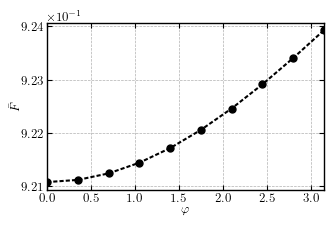

In [133]:
fig, ax = plotlib.create_fig()
ax.plot(arg_list, avg_fid, 'ko',linestyle=(0, (2, 1)))
ax.set_xlabel(r'$\varphi$');
ax.set_ylabel(r'$\bar F$');
ax.grid(linestyle='--', linewidth=.5)
# Format the exponents nicely
ax.ticklabel_format(axis="y", style="sci", scilimits=(-0,-7), useOffset=False, useMathText=False)

### Compute the average gate fidelity for different $\alpha$

In [160]:
alpha_list = np.linspace(1,3,21)
avg_fid = []
## KPO parameters
for alpha in tqdm(alpha_list):
    kpo = KPOProcessor(N=1,alpha=alpha,num_lvl=40)
    alpha = kpo._paras['Coherent state']
    num_lvl = kpo._paras['Cut off']

    ## Cat state
    cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
    cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

    ## Computational basis
    up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
    down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

    ## Pauli Matrices in computational basis
    # Identity
    I = up*up.dag() + down*down.dag()
    # sigma z
    sigma_z = up*up.dag() - down*down.dag()
    # sigma x
    sigma_x = up*down.dag() + down*up.dag()
    # sigma y
    sigma_y = 1j*(-up*down.dag() + down*up.dag())
    sigma = [sigma_x, sigma_y, sigma_z]
    
    # pick an argument
    arg = np.pi/4
    
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RY", 0, None, arg)
    
    ## Ideal gate
    U = (-1j*arg/2*sigma_y).expm()
    
    ## Average Gate Fidelity
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

  0%|          | 0/21 [00:00<?, ?it/s]

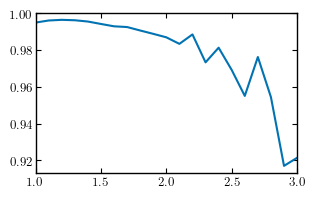

In [165]:
import matplotlib.pyplot as plt
plt.plot(alpha_list, avg_fid)

## Setup parameters for the two-qubit gates

In [166]:
## KPO parameters
kpo = KPOProcessor(N=2,num_lvl=30)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [I,sigma_x, sigma_y, sigma_z]

## RZZ-gate

In [167]:
# Define the Ising-ZZ gate
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

In [142]:
avg_fid = []
## List of angles (Since this takes quite long we can reduce it to two angles)
arg_list = np.linspace(0,np.pi,2)

## Loop over the list of angles and calculate the average gate fidelity
for i, arg in tqdm(enumerate(arg_list)):
    ## Create quantum circuit
    qc = QubitCircuit(N=2)
    qc.user_gates = {"CARB": carb}
    qc.add_gate("CARB", targets = [0,1], arg_value = arg)
    
    ## Ideal gate
    U = (-1j*arg*tensor(sigma_z,sigma_z)/2).expm()
    
    ## Average Gate Fidelity
    d = 4
    F = 0
    for sigma_k in sigma:
        for sigma_l in sigma:
            sigma_kl = tensor(sigma_k,sigma_l)
            ## Master equation
            result = kpo.run_state(init_state=sigma_kl, qc=qc, noisy=False)
            final_state = result.states[-1]
            ## Target state
            target_state = U * sigma_kl.dag() * U.dag()
            F += abs((target_state * final_state).tr())
    avg_fid.append((F + d**2) / (d**2*(d+1)))

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
print("Average gate fidelity:",np.mean(avg_fid))

### Average gate fidelity as function of $\alpha$

In [168]:
alpha_list = np.linspace(1,3,21)
avg_fid = []
## KPO parameters
for alpha in tqdm(alpha_list):
    ## KPO parameters
    kpo = KPOProcessor(N=2,num_lvl=30)
    alpha = kpo._paras['Coherent state']
    num_lvl = kpo._paras['Cut off']

    ## Cat state
    cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
    cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

    ## Computational basis
    up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
    down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

    ## Pauli Matrices in computational basis
    # Identity
    I = up*up.dag() + down*down.dag()
    # sigma z
    sigma_z = up*up.dag() - down*down.dag()
    # sigma x
    sigma_x = up*down.dag() + down*up.dag()
    # sigma y
    sigma_y = 1j*(-up*down.dag() + down*up.dag())
    sigma = [I,sigma_x, sigma_y, sigma_z]

    ## Create quantum circuit
    qc = QubitCircuit(N=2)
    qc.user_gates = {"CARB": carb}
    qc.add_gate("CARB", targets = [0,1], arg_value = arg)
    
    ## Ideal gate
    U = (-1j*arg*tensor(sigma_z,sigma_z)/2).expm()
    
    ## Average Gate Fidelity
    d = 4
    F = 0
    for sigma_k in sigma:
        for sigma_l in sigma:
            sigma_kl = tensor(sigma_k,sigma_l)
            ## Master equation
            result = kpo.run_state(init_state=sigma_kl, qc=qc, noisy=False)
            final_state = result.states[-1]
            ## Target state
            target_state = U * sigma_kl.dag() * U.dag()
            F += abs((target_state * final_state).tr())
    avg_fid.append((F + d**2) / (d**2*(d+1)))

  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 